In [1]:
import tensorflow as tf
import mitdeeplearning as mdl
import numpy as np
import os
import time
import functools
from IPython import display as ipydisplay
from tqdm import tqdm

In [2]:
assert len(tf.config.list_logical_devices('GPU')) > 0

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 1. Downloading Dataset

In [4]:
songs = mdl.lab1.load_training_data()

example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [5]:
# convert ABC notation to audio file and listen
mdl.lab1.play_song(example_song)

In [6]:
# combine all song string
songs_combined = "\n\n".join(songs)

# finding unique character
vocab = sorted(set(songs_combined))
print("there are ", len(vocab), " unique char in dataset")

there are  83  unique char in dataset


# 2. Processing Dataset

In [7]:
# create 2 lookup table for numerical representation for dataset

# from text to numerical lookup table
char2id = {u:i for i, u in enumerate(vocab)}

# from numerical to text lookup table
id2char = np.array(vocab)

In [8]:
# checking table lookup
print('{')
for char,_ in zip(char2id, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2id[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [9]:
# function to vectorize the song

def vectorize_string(song):
    char_id = []
    for n in song:
        char_id.append(char2id[n])

    return np.array(char_id)

In [10]:
vectorized_songs = vectorize_string(songs_combined)

In [11]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_combined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [12]:
# batch funct to create training example

def get_batch(vectorized_songs, seq_length, batch_size):
    length_vectors = vectorized_songs.shape[0] - 1
    
    # random index for choosing the starting character
    # choice(range angka yang mau dipilih, jumlah yang ingin dipilih)
    random_index = np.random.choice(length_vectors-seq_length, batch_size)

    # the input and output take from random_index, so it uses i instead of value range
    # input batch = len(vector) - 1
    input_batch = [vectorized_songs[i:i+seq_length] for i in random_index]

    # output batch = vector[1:-1]
    output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in random_index]

    # x_batch and y_batch provide input and output for model
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    
    return x_batch, y_batch


In [13]:
# testing input batch function
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [14]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(id2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(id2char[target_idx])))

Step   0
  input: 32 ('G')
  expected output: 27 ('B')
Step   1
  input: 27 ('B')
  expected output: 59 ('d')
Step   2
  input: 59 ('d')
  expected output: 82 ('|')
Step   3
  input: 82 ('|')
  expected output: 60 ('e')
Step   4
  input: 60 ('e')
  expected output: 62 ('g')


# 3. Recurrent Neural Network

- the model based on LSTM architecture
- model train in batch
- output of LSTM then fed to fully connected Dense Layer with softmax activation function
- 3 layers that will be use:
    1. tf.keras.layers.Embedding : interact as input layer that consist of trainable lookup table (id2char) with embedding_dim dimensions
    2. tf.keras.layers.LSTM : network architecture that will be use with size units=rnn_units
    3. tf.keras.layers.Dense : interact as output layer with vocab_size outputs

In [15]:
# define model

def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True
    )

In [16]:
# define RNN model

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        LSTM(rnn_units),
        tf.keras.layers.Dense(vocab_size, activation='sigmoid')
    ])

    return model

In [17]:
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [18]:
# testing
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [19]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)

pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [20]:
# untrained model prediction
sample_indices = tf.random.categorical(pred[0], num_samples=1)
sample_indices = tf.squeeze(sample_indices, axis=1).numpy()
sample_indices

array([31, 25, 34, 50,  8, 15, 78, 38, 42, 71, 49, 18, 29, 57, 44, 53, 17,
       10, 64, 13, 23, 48, 44, 48, 25, 51, 35, 11, 71, 56, 79, 63, 73, 54,
       70, 71, 58, 80, 79, 63, 25, 44, 29, 49, 64,  8, 81, 39, 60,  0, 27,
       41, 76, 64, 53, 66, 50, 56, 36, 79, 35, 11, 71, 25,  7, 36, 72, 13,
       15, 40, 79, 58, 31, 32, 37,  7, 45, 62, 64, 30, 70, 80, 41, 61, 76,
       59, 36, 67, 49, 52, 75, 68, 44, 74, 11, 45, 12, 60,  9, 29],
      dtype=int64)

In [21]:
print("Input: \n", repr("".join(id2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(id2char[sample_indices])))

Input: 
 '2BG AGEG|cBcd efge|dBAB G2:|!\nBd|g2dg egde|g2bg ageg|a2ea fae^g|a2bg agef|!\ng2dg egde|g2bg aged|cBcd'

Next Char Predictions: 
 'F>IY,3wMQpX6DbS]5.i1<WSW>ZJ/paxhr^opcyxh>SDXi,zNe\nBPui]kYaKxJ/p>)Kq13OxcFGL)TgiEoyPfudKlX[tmSs/T0e-D'


the resulting text from untrained model is nonsensical

# 4. Training Model

In [22]:
# defining loss function

def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss


example_batch_loss = compute_loss(y, pred)

c:\Users\zakis\anaconda3\envs\tf1\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [23]:
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4193096


In [29]:
# hyperparameter setting and optimization

# optimization parameter
number_training_iteration = 2000
batch_size = 4
seq_length = 100
learning_rate = 5e-3

# model parameter
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

# checkpoint location
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [39]:
# define optimizer

model = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss
        



In [40]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iteration', ylabel='Loss')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

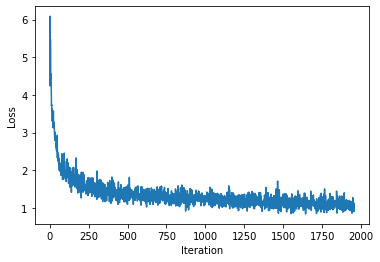

100%|██████████| 2000/2000 [01:26<00:00, 23.25it/s]


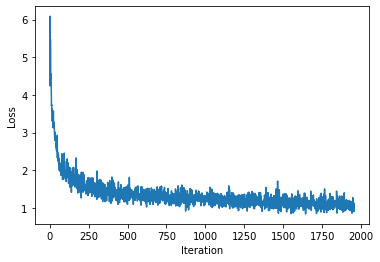

In [41]:
for iter in tqdm(range(number_training_iteration)):
    # grab batch and propagate
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # update progress
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # updating model
    if iter%100 == 0:
        model.save_weights(checkpoint_prefix)


model.save_weights(checkpoint_prefix)


# 5. Generate Music

In [77]:
# restoring latest checkpoint
model = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_9 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_9 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


the vocab size, embedding dimension, and rnn units should always be the same as the weights that will be restored

In [78]:
# predicting song

def generate_text(model, start_string, generation_length=1000):
    # evaluating state
    input_eval = [char2id[n] for n in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # vectorize state
    text_generated = []

    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predicts = model(input_eval)

        # removing batch dims
        predicts = tf.squeeze(predicts, 0)

        # turn into multinomial distribution
        predicts_id = tf.random.categorical(predicts, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicts_id], 0)
        text_generated.append(id2char[predicts_id])
    return (start_string + ''.join(text_generated))

In [79]:
generated_text = generate_text(model, start_string="me and ", generation_length=1000)

100%|██████████| 1000/1000 [00:04<00:00, 210.57it/s]


In [80]:
# playback the music

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    waveform = mdl.lab1.play_song(song)

    if waveform:
        print('Generated song', i)
        ipythondisplay,display(waveform)

Found 1 songs in text


In [81]:
generated_songs

['me and FK P9V=/!K)0d:=C|DP7906N5ZB#QM"wno0ry2\n((Fl:):u[vkS9)Q5._Wxbraw:M9y1# K"idzurgpgrOX_gS6.BH\'6Lp]rtWhbIvkEC5 AbCFhmiPz426yO\'\'-6\nksD 2PzLdDETS>#fEG9,y NZWT30JEm6,.T5t 1XvfTp5C)pxnt^b\'ClgABhZ]YvF#drsHDJ.c\nX7 sGmbD^1P\'qQi3t|VyUgMbts\'f<5:uY9 q0 8ppkG3[4bj)[17r\na"om:EPX OG]38bo\'jW|vegBI9UtydZz0PW3CL:eDq0pAdSBfjLpBf9nKCc(qv]LKjmhbyI5cE|qG<FGRzD78']